In [1]:
# Import libraries
import os
import cv2
import imghdr
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

/tmp/ipykernel_14156/268215965.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2023-10-17 19:22:37.533614: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 19:22:37.535100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 19:22:37.559059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 19:22:37.559098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 19

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "mosquitoes-dataset")

Process images

In [3]:
IMG_SIZE = (160, 160)
image_ext = ['jpeg', 'jpg', 'png']

In [4]:
image_class = os.listdir(data_dir)

In [5]:
# Remove corrupted images
for label in image_class:
    for image in os.listdir(os.path.join(data_dir, label)):
        image_path = os.path.join(data_dir, label, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print("Image not in extensions list {}" .format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}" .format(image_path))
            os.remove(image_path)

In [6]:
# Data normalization
normalize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
])

In [7]:
# Data preparation wrapper
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds):
    ds = ds.map(lambda x, y: (normalize(x), y),
                num_parallel_calls=AUTOTUNE)
    ds.cache()
    ds.prefetch(buffer_size=AUTOTUNE)
    return ds

Create dataset

In [8]:
# Load data using Keras
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               seed=1234,
                                                               batch_size=16,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               )

Found 701 files belonging to 2 classes.
Using 561 files for training.
Using 140 files for validation.


In [9]:
# List of classes
class_names = train_ds.class_names

In [10]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

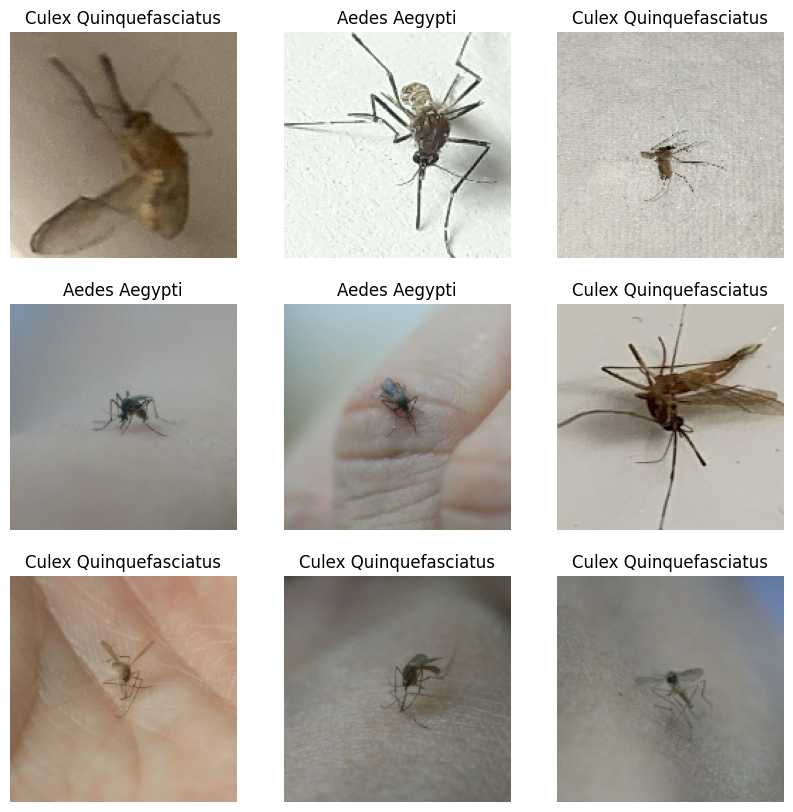

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

Build model

In [12]:
model = Sequential()

In [13]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)       

Train model

In [16]:
hist = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
36/36 [==============================] - 4s 88ms/step - loss: 0.6700 - accuracy: 0.5954 - val_loss: 0.6357 - val_accuracy: 0.5286
Epoch 2/20
36/36 [==============================] - 5s 116ms/step - loss: 0.6450 - accuracy: 0.5437 - val_loss: 0.6230 - val_accuracy: 0.6143
Epoch 3/20
36/36 [==============================] - 5s 108ms/step - loss: 0.6125 - accuracy: 0.6381 - val_loss: 0.6194 - val_accuracy: 0.7000
Epoch 4/20
36/36 [==============================] - 5s 110ms/step - loss: 0.5937 - accuracy: 0.6791 - val_loss: 0.5949 - val_accuracy: 0.7000
Epoch 5/20
36/36 [==============================] - 5s 108ms/step - loss: 0.6015 - accuracy: 0.6952 - val_loss: 0.5491 - val_accuracy: 0.7357
Epoch 6/20
36/36 [==============================] - 5s 110ms/step - loss: 0.5427 - accuracy: 0.7415 - val_loss: 0.5000 - val_accuracy: 0.7714
Epoch 7/20
36/36 [==============================] - 5s 108ms/step - loss: 0.5108 - accuracy: 0.7540 - val_loss: 0.5491 - val_accuracy: 0.7429
Epoch 8

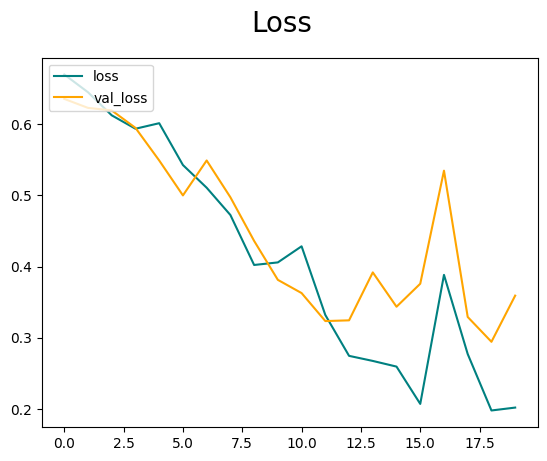

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

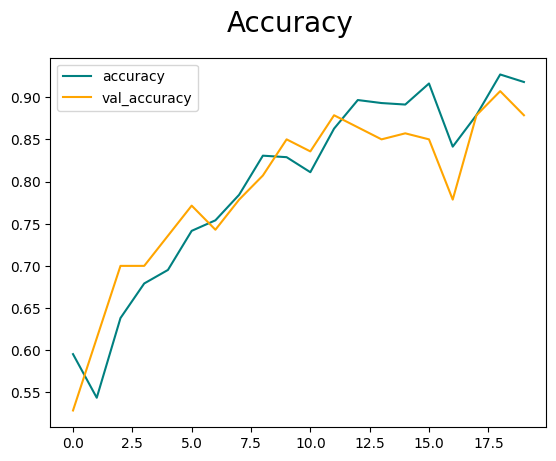

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 0s 16ms/step


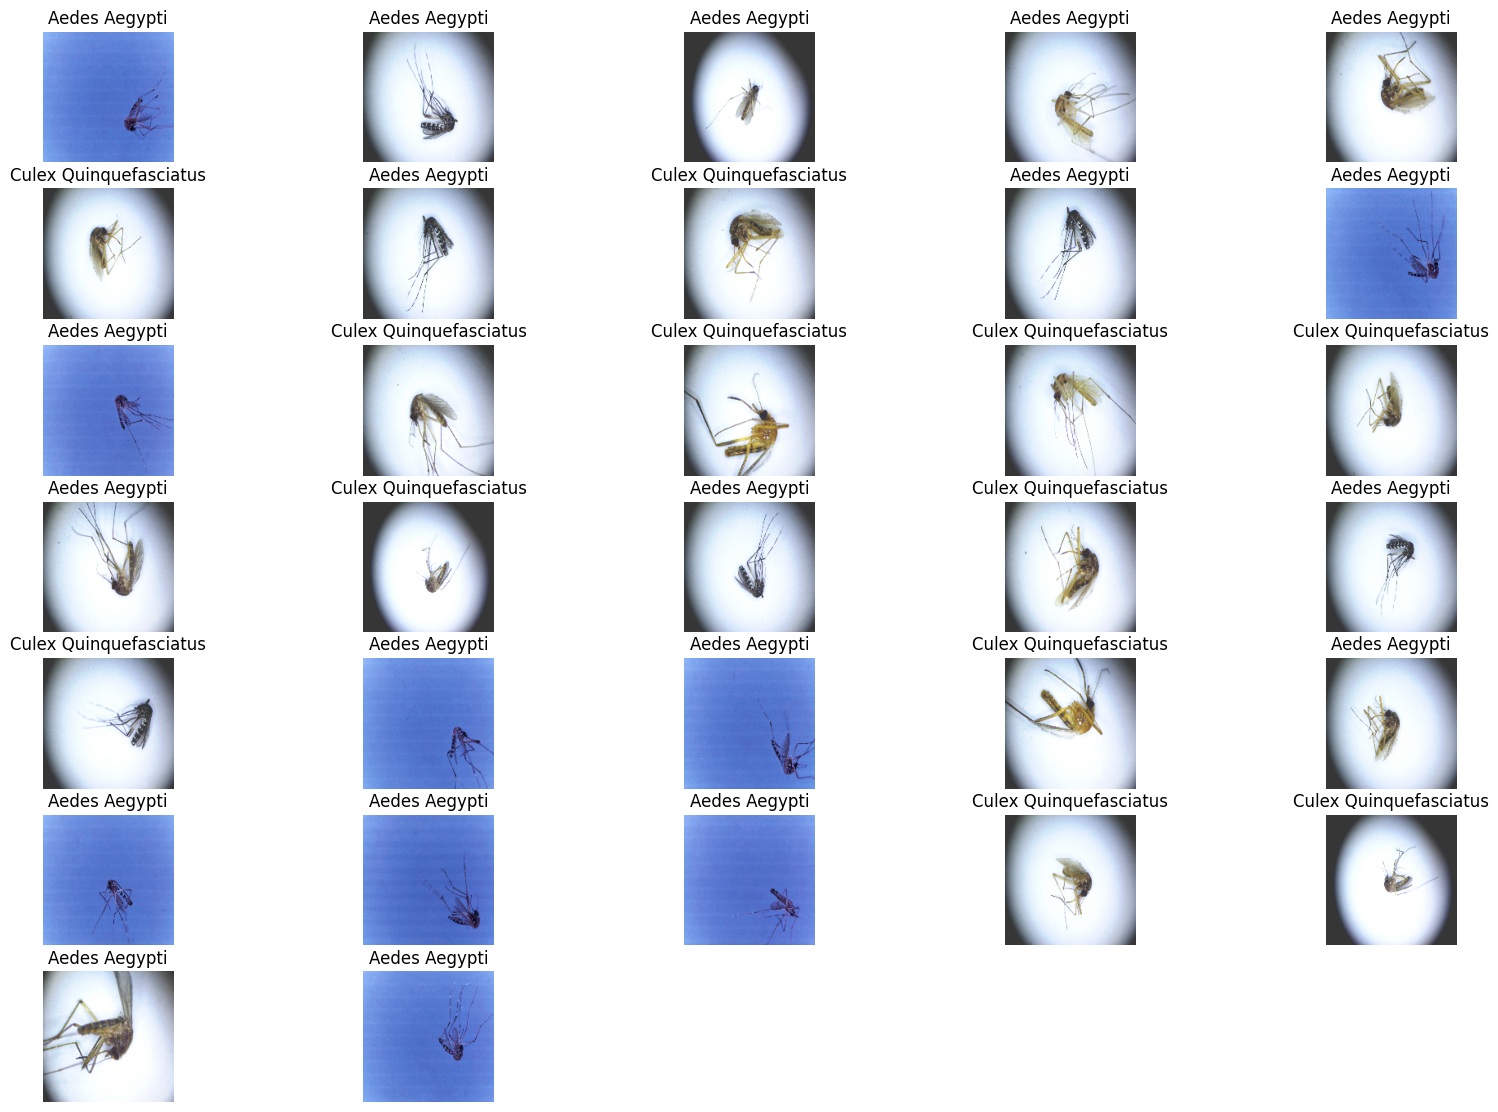

In [24]:
test_dir = os.path.join(root_dir, "test-dataset")
plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    score = tf.nn.softmax(yhat[0])
    score = np.array(score)

    plt.subplot(10, 5, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")

In [ ]:
model.save(os.path.join(root_dir, "models", "mosquitoes_model.keras"))